In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from numpy.linalg import norm
from math import acos, sqrt

def get_angle(v_in, mode) :
    '''  This function obtains converts vector information 
         into angle for encrypting classical information to
         quantum information style.
         
         INPUT: 
         mode  =======> 0 uses projection into |psi_0>| 1 uses exponential to convert it
         v_in  =======> desired quantum state's (vector) angle
         TODO:
         v0_in =======> this can be tunned but meant to be |psi_0> (very initial quantum state/vector)
         OUTPUT:
         proj ========> array of projected quantum states in to reference quantum state 
                        ang = <psi_k | psi_0>/ ( norm(psi_k) * norm(psi_0) )
                        in practice norm(psi_k) has to be 1 given that are in unit circle description
    '''
    
    # Probability vector
    v_in = np.squeeze( np.asarray(v_in) )
    # "Basis" or vector to project 
    #v0_in= np.squeeze( np.asanyarray(v0_in))
    # |0> state
    v0 = np.array((1,0))
    # |1> state 
    #v0 = np.array((0,1))
    # |+> state 
    #v0 = np.array((1,1))/sqrt(2)
    
    vshape = v_in.shape
    nq = vshape[0]
   
    proj = np.zeros(nq)
    if mode == 0 :
        # Angle projection into |v0> state
        for iq in range(nq) :
            proj[iq] = acos(np.dot( v_in[iq,:] , v0)) # project to |0> basis
            
    #elif mode == 1 : 
        # Angle defined in terms of exponents
        
        
    elif mode == 3 :
        for i in range(nq):
            proj[iq] = pi/2

    #else
        # Not defined
    
    return proj

In [8]:
def get_statesNprobs(quantum_state, n, rho):
    # This will write back binary string to 
    # hidden and visual states 
    # will provide the probabilities associated to the given states
    
    nq = sum(n) + n[0]*n[1]
    
    vis_state = np.zeros(n[0])
    hid_state = np.zeros(n[1])
    
    # Obtaining the visual and hidden states "binary"
    jq = -1
    for iq in range(nq-1,-1,-1): 
        jq = jq + 1 
        print("iq number :", iq, quantum_state[iq])
        if (iq > nq - n[0]) & (iq <= nq): 
            vis_state[jq] = int(quantum_state[iq])  
    
        elif (iq > nq -sum(n)) & (iq <= nq - n[0]):
            hid_state[jq-n[0]] = int(quantum_state[iq])


    # Probabilities of measuring only qubit-i in a given state
    qprobs = np.zeros((nq,2))
    cprobs = np.zeros((nq))
    for iq in range(nq):
        # Passing quantum state probabilities
        qprobs[iq] = rho.probabilities([iq])
        print('Qubit-{} probs: {}'.format(iq, qprobs[iq]))

        if quantum_state[iq] == "0":
            # Probably only assing the state one probability only?
            # this is equivalent to <0|q_i> = qprob_i in state |0>
            #cprobs[iq] = qprobs[iq,0]
            cprobs[iq] = qprobs[iq,1]
        else:
            # this is equivalent to <1|q_i> = qprob_i in state |1>
            cprobs[iq] = qprobs[iq,1]


{'00000100': 97, '00000110': 3, '01000110': 15, '00000000': 549, '00001000': 95, '11001110': 3, '00000010': 90, '00000001': 84, '00101001': 16, '00111101': 2, '00001100': 13, '00010101': 18, '10001010': 16, '00000011': 14, '10101011': 2, '00001001': 1, '00001010': 1, '00010111': 1, '00000101': 3, '10001110': 1}
        ┌─────────┐                                                 ░ ┌─┐      »
   q_0: ┤ Ry(π/4) ├─────■───────────■───────────────────────────────░─┤M├──────»
        ├─────────┤     │           │                               ░ └╥┘┌─┐   »
   q_1: ┤ Ry(π/4) ├─────┼───────────┼───────────■───────────■───────░──╫─┤M├───»
        ├─────────┤     │           │           │           │       ░  ║ └╥┘┌─┐»
   q_2: ┤ Ry(π/4) ├─────■───────────┼───────────■───────────┼───────░──╫──╫─┤M├»
        ├─────────┤     │           │           │           │       ░  ║  ║ └╥┘»
   q_3: ┤ Ry(π/4) ├─────┼───────────■───────────┼───────────■───────░──╫──╫──╫─»
        └─────────┘┌────┴─────┐     │  

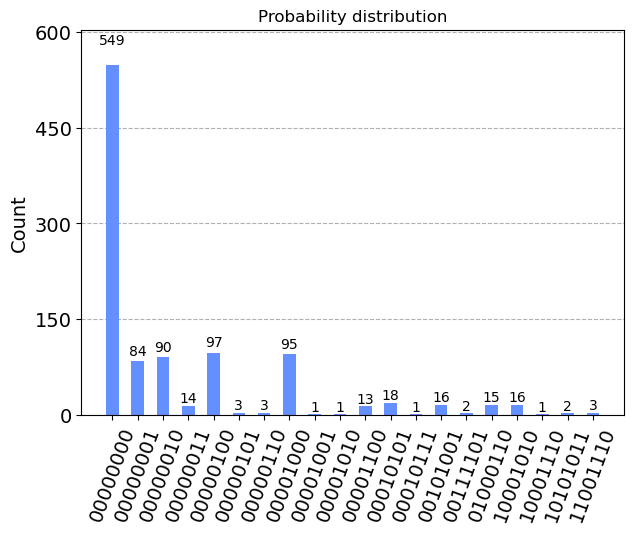

In [9]:
import qiskit
from qiskit import Aer, execute, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.primitives import Sampler 
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import RYGate
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector, DensityMatrix



#---------------------------------------------------------------------------
# I want the best configuration, thus the peak of the probability distribution
# then retrieve the probabilities according to that state 
# and provide states and probabilities
#---------------------------------------------------------------------------

# Number of shots for quantum simulation
nshots = 1000

n_vis = 2
n_hid = 2
# n(0) and n(1) contain the number of visual and hidden nodes
n = [n_vis, n_hid] 

# Double the number of qubits for ancilla gates
nq = sum(n) + n[0]*n[1]

circ = qiskit.QuantumCircuit(nq)

# Initial state of visual nodes
avec = np.ones((n[0],2))/sqrt(2)
ang = get_angle(avec,mode=0)
for iq in range(n[0]) :
    circ.ry(ang[iq],iq)
    #circ.ry(0,iq)
    
# Initial state of hidden nodes
bvec = np.ones((n[1],2))/sqrt(2)
ang = get_angle(bvec,0)
for iq in range(n[1]) :
    circ.ry(ang[iq],n[0]+iq)
    #circ.ry(0,n[0]+iq)    

mq = sum(n) - 1
for iq in range(n[0]) :
    for jq in range(n[1]) :
        
        mq = mq + 1
        ccry = RYGate(3*pi/4).control(2)
        #ccry = RYGate(0).control(2)
        # Controlling iq -> visual layer, jq -> hidden layer, mq -> worker qubit
        circ.append(ccry, [iq, n[0]+jq, mq ])

        
rho = DensityMatrix(circ)

# Probabilities for measuring only qubit-i
qprobs = np.zeros((nq,2))
for iq in range(nq):
    qprobs[iq] = rho.probabilities([iq])
    #print('Qubit-{} probs: {}'.format(iq, qprobs[iq]))

circ.measure_all()

# Run the quantum circuit on a statevector simulator backend
#sim_mode = 'qasm_simulator'
sim_mode = 'aer_simulator'

simulator = Aer.get_backend(sim_mode)

# Transpile reshapes the circuit to match quantum device topology (optimize circuit)
#circ = transpile(circ, simulator)
#result = simulator.run(circ,shots=nshots).result()
#counts = result.get_counts(circ)

result = execute(circ, simulator).result()
counts = result.get_counts(circ)

print(counts)

# Access all the states and counts
#count_keys=list(counts.keys())
#ikey=count_keys[0]
#counts.get(ikey)

# Most frequent state and probability
most_freq = counts.most_frequent()
most_freq_prob = counts.get(most_freq)/nshots

print(circ)
plot_histogram(counts, title='Probability distribution')




In [123]:
count_keys=list(counts.keys())
msize = len(count_keys)
res = []
k = 0
for istr in count_keys:
    res.append( [istr, counts.get(istr) ] )
    k += 1

print(res)
#res.sort()


res = sorted(res,key=lambda x: x[1],reverse=True)
res[0][1]

[['00000100', 108], ['11011111', 1], ['00000000', 349], ['01000110', 23], ['00001000', 101], ['00001010', 2], ['01000111', 1], ['00000001', 128], ['00111101', 7], ['01001110', 3], ['00001100', 26], ['11001110', 6], ['00000010', 116], ['00010101', 29], ['10101011', 11], ['10001010', 24], ['00101001', 29], ['11111111', 1], ['00000110', 5], ['00000011', 27], ['00001001', 7], ['00010111', 2], ['00001101', 1], ['01010111', 9], ['00000101', 4], ['10001011', 1], ['00011101', 2], ['10001110', 1]]


349

In [92]:

array = np.array([ [1, 0], [1,0]])
v0 = np.ones(2)
v0 = v0/norm(v0)
v1 = np.array([ [1/sqrt(2),1/sqrt(2),0,0],[-1/sqrt(2),-1/sqrt(2),0,0] ])
#val = get_angle(v1,v0,0)
val = get_angle(array,v0,0)
val

shape of array : (2, 2)


[0.7853981633974484, 0.7853981633974484]

In [3]:
from qiskit import QuantumCircuit, QuantumRegister
qr = QuantumRegister(3)
control_qubits = qr[:2]
target_qubit = qr[2]
circuit = QuantumCircuit(qr)
circuit.mcry(0.12, control_qubits, target_qubit)
circuit.draw()

q7_0: ──────────────■─────────────────■──
                    │                 │  
q7_1: ──────────────■─────────────────■──
      ┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐
q7_2: ┤ Ry(0.06) ├┤ X ├┤ Ry(-0.06) ├┤ X ├
      └──────────┘└───┘└───────────┘└───┘